# Detecting open doors using object detection
This notebooks uses an RTSP camera to acquire images and send them to LandngLens for analysis

In [6]:
#@title Set the following variables as needed for your setup
api_key         = "zm7ml657kh9a370k9liluxg9heuoufv"  #@param {type:"string"}
api_secret      = "1ccnesqy4em8dc32k2h2cu5kovdcd6palepaw4ugly6ttfl2fylu340x7ecja0"  #@param {type:"string"}
model_endpoint  =  "2d299622-434f-4ce9-b2eb-1142cdcfafcc" #@param {type:"string"}


## Utility functions (temporary until we publish to cloud)

In [7]:
# Load LandingLens library from the local repo
import sys, os
sys.path.append("../../modules/src")

In [8]:
# Define function to aquire images from the web browser
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/tmp/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Acquire image from camera

<IPython.core.display.Javascript object>

Saved to /tmp/photo.jpg


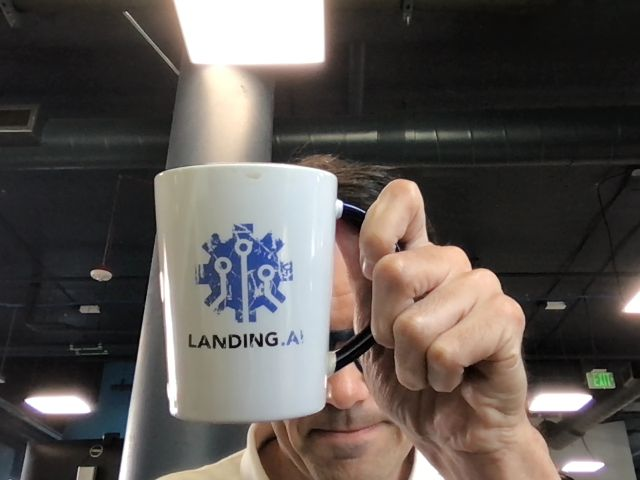

In [9]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Run the object detection model on LandingLens cloud

In [10]:
from landingai.predict import Predictor
from landingai.visualize import draw_bboxes
        
predictor = Predictor(model_endpoint, api_key, api_secret)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

ModuleNotFoundError: ignored

## Visualize results

In [ ]:
# Draw raw results on the original image
frame = draw_bboxes(results, image=frame)
plt.imshow(frame)
plt.title(camera_url)
plt.show()


## Process results to determine if the door is open or closed

In [ ]:
from IPython.display import display, Markdown
# For better accuracy we look at the top detection and only claim that hte door is closed if we identify it as such. If the door is partially open or fully open it will be reported as open
top_detection = max(results, key=lambda x: x['confidence_score'])
if top_detection['label'] == "Closed":
    display(Markdown('# The door is not open'))
else:
    display(Markdown('# The door is open'))
